# Sentiment Analysis of Amazon Fine Food Reviews

### Amazon fine food reviews data set was downloaded from Kaggle.

The intention is to build a model which can perform sentiment analysis on the opinions expressed by the customers in a piece of text and based on this analysis determine whether the customer sentiment is positive or negative.

### Data import and exploration

In [1]:
import pandas as pd
import numpy as np

In [2]:
ar = pd.read_csv('AMAZON-1L.csv')
ar.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,#* ++-- #Product'' >arri>ved labeled as Jumbo...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
ar.shape

(106800, 10)

In [4]:
ar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106800 entries, 0 to 106799
Data columns (total 10 columns):
Id                        106800 non-null int64
ProductId                 106800 non-null object
UserId                    106800 non-null object
ProfileName               106795 non-null object
HelpfulnessNumerator      106800 non-null int64
HelpfulnessDenominator    106800 non-null int64
Score                     106800 non-null int64
Time                      106800 non-null int64
Summary                   106796 non-null object
Text                      106800 non-null object
dtypes: int64(5), object(5)
memory usage: 8.1+ MB


In [5]:
ar.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               5
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   4
Text                      0
dtype: int64

### We would be using only the score and Text columns for our analysis and hence no missing value treatment is required as there are no missing values in these coloumns.

#### Checking the score wise no of observations

In [6]:
ar.groupby(['Score']).size()

Score
1    10001
2     5867
3     8488
4    15578
5    66866
dtype: int64

In [7]:
ar[ar['Score'] != 3]['Id'].count()

98312

#### Selecting the required columns for our analysis

In [8]:
ar=ar[['Score','Text']]

### Data preparation

#### Score variable has values from 1 to 5. We consider values 1,2 as negative sentiment, 3 as neutral and 4 and 5 as positive sentiment. Hence we will eliminate all observations with score 3.

In [9]:
ar = ar[ar['Score'] != 3]

#### Creating a new coloumn Positivity where scores above 3 are encoded as 1 which is positive sentiment and scores below 3 are encoded as 0 which is negative sentiment.

In [10]:
ar['Positivity'] = np.where(ar['Score'] > 3, 1, 0)
ar.head()

,Score,Text,Positivity
0,5,I have bought several of the Vitality canned d...,1
1,1,#* ++-- #Product'' >arri>ved labeled as Jumbo...,0
2,4,This is a confection that has been around a fe...,1
3,2,If you are looking for the secret ingredient i...,0
4,5,Great taffy at a great price. There was a wid...,1


In [11]:
ar['Positivity'].unique()

array([1, 0], dtype=int64)

In [12]:
ar.groupby(['Positivity']).size()

Positivity
0    15868
1    82444
dtype: int64

#### The data is imbalanced with only 16% of observations in the negative category. Hence we would use under sampling technique to balance the data. We would increase the % of negative observations to 33%.

### Random under sampling technique to balance the data set.

In [13]:
# Perform undersampling majority group
minorityN = len(ar[ar.Positivity == 0])*2
minority_indices = ar[ar.Positivity == 0].index
minority_sample = ar.loc[minority_indices]

In [14]:
majority_indices = ar[ar.Positivity == 1].index
 # use the low-frequency group count to randomly sample from high-frequency group
random_indices = np.random.choice(majority_indices, minorityN, replace=False)
majority_sample = ar.loc[random_indices]

In [15]:
# merging all the low-frequency group sample and the new (randomly selected) high-frequency sample together
merged_sample = pd.concat([minority_sample, majority_sample], ignore_index=True) 

In [16]:
ar=merged_sample

In [17]:
ar.head()

,Score,Text,Positivity
0,1,#* ++-- #Product'' >arri>ved labeled as Jumbo...,0
1,2,If you are looking for the secret ingredient i...,0
2,1,My cats have been happily eating Felidae Plati...,0
3,2,I love eating them and they are good for watch...,0
4,1,"The candy is just red , No flavor . Just plan...",0


In [18]:
ar.groupby(['Positivity']).size()

Positivity
0    15868
1    31736
dtype: int64

### We would use the NLP techniques to clean the text and covert it into a bag of words which would be later converted to a matrix of token counts.

#### Converting to lowercase

In [19]:
ar['Text'] = ar['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
ar['Text'].head()

0    #* ++-- #product'' >arri>ved labeled as jumbo ...
1    if you are looking for the secret ingredient i...
2    my cats have been happily eating felidae plati...
3    i love eating them and they are good for watch...
4    the candy is just red , no flavor . just plan ...
Name: Text, dtype: object

#### Removing all Punctuation, Special characters

In [20]:
ar['Text']=ar['Text'].str.replace('[^\w\s]','')

In [21]:
ar['Text'].head()

0      product arrived labeled as jumbo salted pean...
1    if you are looking for the secret ingredient i...
2    my cats have been happily eating felidae plati...
3    i love eating them and they are good for watch...
4    the candy is just red  no flavor  just plan an...
Name: Text, dtype: object

#### Stop words removal

In [22]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Prabha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
ar['Text'] = ar['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stopwords))
ar['Text'].head()

0    product arrived labeled jumbo salted peanutsth...
1    looking secret ingredient robitussin believe f...
2    cats happily eating felidae platinum two years...
3    love eating good watching tv looking movies sw...
4          candy red flavor plan chewy would never buy
Name: Text, dtype: object

#### Common words removal as these words do not add any value to the analysis

In [24]:
freq = pd.Series(' '.join(ar['Text']).split()).value_counts()[:10]
freq

br         23154
like       22123
good       15711
one        14620
taste      14556
product    13179
great      12257
flavor     11679
coffee     11378
would      11195
dtype: int64

In [25]:
type(freq)

pandas.core.series.Series

#### As 'like', 'good', 'great' are considered positive, except these the other words are removed

In [26]:
freq=freq.drop(freq.index[[1,2,6]])

In [27]:
freq

br         23154
one        14620
taste      14556
product    13179
flavor     11679
coffee     11378
would      11195
dtype: int64

In [28]:
freq = list(freq.index)
ar['Text'] = ar['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
ar['Text'].head()

0    arrived labeled jumbo salted peanutsthe peanut...
1    looking secret ingredient robitussin believe f...
2    cats happily eating felidae platinum two years...
3    love eating good watching tv looking movies sw...
4                       candy red plan chewy never buy
Name: Text, dtype: object

#### Rare words removal as these words do not add any value to the analysis

In [29]:
freq = pd.Series(' '.join(ar['Text']).split()).value_counts()[-50:]
freq

roastgrilled           1
houseto                1
currantsbr             1
caloriethey            1
largers                1
sodahellothe           1
sourcream              1
convoluted             1
2gms                   1
interfaces             1
feverbr                1
gerrym                 1
clened                 1
whered                 1
maltesepoodle          1
intensed               1
libation               1
akitas                 1
tetrpak                1
ice20                  1
qtip                   1
germanenglish          1
dissenter              1
astonishes             1
chaiaholic             1
captains               1
organismbr             1
fleabr                 1
indianspiced           1
stewi                  1
butterits              1
deemedbr               1
impressedas            1
staleseeming           1
uneaven                1
profuct                1
dudesame               1
datsun                 1
6inch                  1
forthis                1


In [30]:
freq = list(freq.index)
ar['Text'] = ar['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
ar['Text'].head()

0    arrived labeled jumbo salted peanutsthe peanut...
1    looking secret ingredient robitussin believe f...
2    cats happily eating felidae platinum two years...
3    love eating good watching tv looking movies sw...
4                       candy red plan chewy never buy
Name: Text, dtype: object

#### Lemmatization to convert the words to their basic form

In [31]:
import nltk
wn = nltk.WordNetLemmatizer()
from nltk.tokenize import word_tokenize 

In [32]:
def lemmatizing(original_text):
    tokenized_text=word_tokenize(original_text)
    text = [wn.lemmatize(word, pos="v") for word in tokenized_text]
    return text

ar['Text_lemmatized'] = ar['Text'].apply(lambda x: lemmatizing(x))

ar.head(10)

,Score,Text,Positivity,Text_lemmatized
0,1,arrived labeled jumbo salted peanutsthe peanut...,0,"[arrive, label, jumbo, salt, peanutsthe, peanu..."
1,2,looking secret ingredient robitussin believe f...,0,"[look, secret, ingredient, robitussin, believe..."
2,1,cats happily eating felidae platinum two years...,0,"[cat, happily, eat, felidae, platinum, two, ye..."
3,2,love eating good watching tv looking movies sw...,0,"[love, eat, good, watch, tv, look, movies, swe..."
4,1,candy red plan chewy never buy,0,"[candy, red, plan, chewy, never, buy]"
5,1,oatmeal good mushy soft dont like quaker oats ...,0,"[oatmeal, good, mushy, soft, dont, like, quake..."
6,1,arrived 6 days stale could eat 6 bags,0,"[arrive, 6, days, stale, could, eat, 6, bag]"
7,2,purchased mango doesnt take like mango hint sw...,0,"[purchase, mango, doesnt, take, like, mango, h..."
8,1,buyer beware please sweetener everybody maltit...,0,"[buyer, beware, please, sweetener, everybody, ..."
9,2,okay go way buy,0,"[okay, go, way, buy]"


#### Dropping the text coloumn and using the lemmatized text coloumn

In [33]:
type(ar)

pandas.core.frame.DataFrame

In [34]:
ar=ar.drop('Text',1)

In [35]:
ar = ar.rename(columns={'Text_lemmatized': 'Text'})

In [36]:
ar['Text'] = ar['Text'].apply(lambda x: ','.join(map(str, x)))

In [37]:
ar['Text']=ar['Text'].str.replace('[^\w\s]',' ')

In [38]:
ar.head()

,Score,Positivity,Text
0,1,0,arrive label jumbo salt peanutsthe peanuts act...
1,2,0,look secret ingredient robitussin believe find...
2,1,0,cat happily eat felidae platinum two years get...
3,2,0,love eat good watch tv look movies sweet like ...
4,1,0,candy red plan chewy never buy


#### Using word cloud to view words with high frequency with positive and negative scores.

In [39]:
arp=ar[ar['Positivity'] == 1]

In [40]:
arn=ar[ar['Positivity'] == 0]

In [41]:
freqp= pd.Series(' '.join(arp['Text']).split()).value_counts()

In [42]:
freqp.head(10)

like     15133
love     11613
good     11519
great    10609
get      10105
make      9828
use       9491
try       9108
buy       7998
tea       7927
dtype: int64

In [43]:
freqn = pd.Series(' '.join(arn['Text']).split()).value_counts()

In [44]:
freqn.head(10)

like    9299
buy     6002
get     5855
try     5111
make    4854
good    4192
use     4133
eat     4081
food    3974
dog     3926
dtype: int64

In [45]:
from wordcloud import WordCloud

In [46]:
wp = WordCloud().generate(' '.join(arp['Text']))

In [47]:
wn = WordCloud().generate(' '.join(arn['Text']))

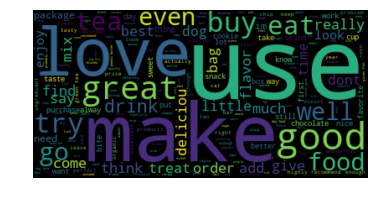

In [48]:
import matplotlib.pyplot as plt
plt.imshow(wp,interpolation='bilinear')
plt.axis("off")
plt.show()

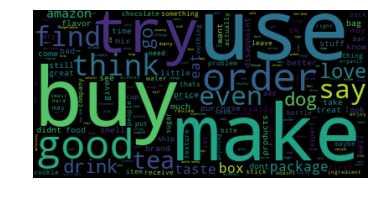

In [49]:
import matplotlib.pyplot as plt
plt.imshow(wn,interpolation='bilinear')
plt.axis("off")
plt.show()

### Train-Test split using SciKit learn

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
X_train, X_test, y_train, y_test = train_test_split(ar['Text'], ar['Positivity'], test_size=0.3, random_state =100)

In [52]:
print('\nX_train shape: ', X_train.shape)
print('\nX_test shape: ', X_test.shape)


X_train shape:  (33322,)

X_test shape:  (14282,)


### CountVectorizer to Convert a collection of text to a matrix of token counts. Hyperparameters are passed to delete Stop words and also create bigrams.

In [53]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer( stop_words='english', ngram_range=(1,2)).fit(X_train)
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [54]:
vect.get_feature_names()[::2000]

['00',
 '12 diameter',
 '1688 bpp',
 '20yr',
 '300 24oz',
 '48 pod',
 '6g wish',
 'able attest',
 'acid nearly',
 'add difficult',
 'adjust immediately',
 'afternoon treat',
 'air active',
 'allpurpose flour',
 'amaze salt',
 'american pavilion',
 'anymore generic',
 'appointments teeth',
 'arrangementsand return',
 'assam 30lb',
 'available customers',
 'awesome lunch',
 'bad la',
 'bag totw',
 'bannana taste',
 'base pet',
 'bean doubt',
 'beer youd',
 'bernie 6065',
 'better equip',
 'big pencil',
 'bite niacin',
 'blaha hrefhttpwwwamazoncomgpproductb001d05rwckind',
 'blueberry lemon',
 'boost benefit',
 'bowl think',
 'brace youre',
 'bread work',
 'brewer die',
 'brush rinse',
 'burgerinduced demise',
 'buy area',
 'buy yamamotoyama',
 'calm respiratory',
 'candyar arrrrh',
 'carbs generally',
 'cart remember',
 'catagory wont',
 'cereal happen',
 'change kibble',
 'checkups amazon',
 'cherry white',
 'chiguagua',
 'chip unmistakablea',
 'chocolaty delight',
 'ciao',
 'clear good'

In [55]:
len(vect.get_feature_names())

618358

In [56]:
X_train_vectorized = vect.transform(X_train)
X_test_vectorized = vect.transform(X_test)
X_train_vectorized

<33322x618358 sparse matrix of type '<class 'numpy.int64'>'
	with 2055682 stored elements in Compressed Sparse Row format>

#### Standardizing the data

In [57]:
from sklearn.preprocessing import StandardScaler

In [58]:
sc = StandardScaler(with_mean=False)
std_scale = sc.fit(X_train_vectorized)

C:\Users\Prabha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [59]:
X_train_vectorized_s = std_scale.transform(X_train_vectorized)
X_test_vectorized_s = std_scale.transform(X_test_vectorized)

In [60]:
#X_train_vectorized = X_train_vectorized_s

In [61]:
X_train_vectorized_s[:5,]

<5x618358 sparse matrix of type '<class 'numpy.float64'>'
	with 496 stored elements in Compressed Sparse Row format>

### Fitting Logistic Regression without standardizing data

In [62]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

C:\Users\Prabha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### Accuracy Score, Precision Score, Recall Score, f1 Score

In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [64]:
predictions = model.predict(X_test_vectorized)

In [65]:
from sklearn.metrics import classification_report

print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      4774
           1       0.91      0.94      0.93      9508

   micro avg       0.90      0.90      0.90     14282
   macro avg       0.89      0.88      0.89     14282
weighted avg       0.90      0.90      0.90     14282



In [66]:
accuracy_score(y_test, predictions)

0.900714185688279

#### Confusion Matrix

In [67]:
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [68]:
confusion_mat = confusion_matrix(y_test, predictions)

In [69]:
confusion_df = pd.DataFrame(confusion_mat, index=['Actual neg','Actual pos'], columns=['Predicted neg','Predicted pos'])

In [70]:
confusion_df

,Predicted neg,Predicted pos
Actual neg,3904,870
Actual pos,548,8960


#### AUC and Threshold Probability

In [71]:
from sklearn.metrics import roc_curve, roc_auc_score

In [72]:
probs = model.predict_proba(X_test_vectorized)[:, 1]

In [73]:
fpr, tpr, threshold = roc_curve(y_test, probs)

In [74]:
import matplotlib.pyplot as mpl

In [75]:
auc = roc_auc_score(y_test, probs)
print(auc)

0.9514516604895505


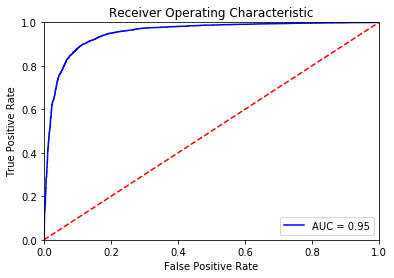

In [76]:
mpl.title('Receiver Operating Characteristic')
mpl.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
mpl.legend(loc = 'lower right')
mpl.plot([0, 1], [0, 1],'r--')
mpl.xlim([0, 1])
mpl.ylim([0, 1])
mpl.ylabel('True Positive Rate')
mpl.xlabel('False Positive Rate')
mpl.show()

In [77]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]

In [78]:
optimal_threshold

0.7302185694461213

#### Evaluation metrics using threshold probability

In [79]:
new_predictions = np.where(probs>optimal_threshold, 1, 0)

In [80]:
new_confusion_mat = confusion_matrix(y_test, new_predictions)

In [81]:
new_confusion_df = pd.DataFrame(new_confusion_mat, index=['Actual neg','Actual pos'], columns=['Predicted neg','Predicted pos'])

In [82]:
new_confusion_df

,Predicted neg,Predicted pos
Actual neg,4236,538
Actual pos,984,8524


In [83]:
print(classification_report(y_test,new_predictions))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      4774
           1       0.94      0.90      0.92      9508

   micro avg       0.89      0.89      0.89     14282
   macro avg       0.88      0.89      0.88     14282
weighted avg       0.90      0.89      0.89     14282



In [84]:
accuracy_score(y_test, new_predictions)

0.893432292396023

In [85]:
feature_names = np.array(vect.get_feature_names())
sorted_coef_index = model.coef_[0].argsort()
print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs: 
['worst' 'disappoint' 'terrible' 'awful' 'horrible' 'return'
 'disappointment' 'bland' 'stale' 'cancel']

Largest Coefs: 
['delicious' 'awesome' 'excellent' 'perfect' 'amaze' 'wonderful' 'yummy'
 'best' 'wont disappoint' 'smooth']



#### The accuracy and other scores seems to have decreased slightly after using the threshold values.

### Fitting Logistic Regression with standardization

In [86]:
from sklearn.linear_model import LogisticRegression
models = LogisticRegression()
models.fit(X_train_vectorized_s, y_train)

C:\Users\Prabha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### Accuracy Score, Precision Score, Recall Score, f1 Score

In [87]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [88]:
predictions = models.predict(X_test_vectorized_s)

In [89]:
from sklearn.metrics import classification_report

print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.91      0.61      0.73      4774
           1       0.83      0.97      0.90      9508

   micro avg       0.85      0.85      0.85     14282
   macro avg       0.87      0.79      0.81     14282
weighted avg       0.86      0.85      0.84     14282



In [90]:
accuracy_score(y_test, predictions)

0.8499509872566867

#### AUC

In [91]:
from sklearn.metrics import roc_auc_score
probs = models.predict_proba(X_test_vectorized_s)[:, 1]
print('AUC: ', roc_auc_score(y_test, probs))

AUC:  0.9160512903031937


In [92]:
feature_names = np.array(vect.get_feature_names())
sorted_coef_index = model.coef_[0].argsort()
print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs: 
['worst' 'disappoint' 'terrible' 'awful' 'horrible' 'return'
 'disappointment' 'bland' 'stale' 'cancel']

Largest Coefs: 
['delicious' 'awesome' 'excellent' 'perfect' 'amaze' 'wonderful' 'yummy'
 'best' 'wont disappoint' 'smooth']



#### The classification models below are based on non standardized data as the accuracy in logistic regression has yeided better accuracy for non standardized data.

### Fitting Logistic Regression after using Tfid Transformer

In [93]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_vectorized)
X_train_tfidf.shape

(33322, 618358)

In [94]:
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression()
model1.fit(X_train_tfidf, y_train)

C:\Users\Prabha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### Accuracy Score, Precision Score, Recall Score, f1 Score

In [95]:
predictions = model1.predict(X_test_vectorized)

In [96]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.83      0.76      0.79      4774
           1       0.88      0.92      0.90      9508

   micro avg       0.87      0.87      0.87     14282
   macro avg       0.86      0.84      0.85     14282
weighted avg       0.87      0.87      0.87     14282



In [97]:
accuracy_score(y_test, predictions)

0.8682957568967932

#### AUC

In [98]:
from sklearn.metrics import roc_auc_score
probs1 = model1.predict_proba(X_test_vectorized)[:, 1]
print('AUC: ', roc_auc_score(y_test, probs1))

AUC:  0.9223163163461316


In [99]:
feature_names = np.array(vect.get_feature_names())
sorted_coef_index = model1.coef_[0].argsort()
print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs: 
['disappoint' 'return' 'bad' 'worst' 'throw' 'horrible' 'terrible' 'awful'
 'money' 'think']

Largest Coefs: 
['great' 'love' 'best' 'delicious' 'perfect' 'nice' 'good' 'excellent'
 'favorite' 'wonderful']



### Fitting Multinomial Naive Bayes 

In [100]:
from sklearn.naive_bayes import MultinomialNB

In [101]:
model2 = MultinomialNB()

In [102]:
model2.fit(X_train_vectorized, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

#### Accuracy Score, Precision Score, Recall Score, f1 Score

In [103]:
predictions = model2.predict(X_test_vectorized)

In [104]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.94      0.62      0.75      4774
           1       0.84      0.98      0.90      9508

   micro avg       0.86      0.86      0.86     14282
   macro avg       0.89      0.80      0.82     14282
weighted avg       0.87      0.86      0.85     14282



In [105]:
accuracy_score(y_test, predictions)

0.8587032628483405

In [106]:
probs2 = model2.predict_proba(X_test_vectorized)[:, 1]
print('AUC: ', roc_auc_score(y_test, probs2))

AUC:  0.9177294462767136


In [107]:
feature_names = np.array(vect.get_feature_names())
sorted_coef_index = model2.coef_[0].argsort()
print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs: 
['dog family' 'review equate' 'exist dissapointing' 'exist drink'
 'exist excite' 'exist fact' 'review effectiveness' 'exist gas'
 'review edible' 'review eat']

Largest Coefs: 
['like' 'love' 'good' 'great' 'make' 'use' 'try' 'buy' 'tea' 'eat']



### Random Forest Classifier

In [108]:
from sklearn.ensemble import RandomForestClassifier

In [109]:
rf_model = RandomForestClassifier(n_estimators=40, n_jobs=-1)

In [110]:
rf_model.fit(X_train_vectorized, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [111]:
predictions = rf_model.predict(X_test_vectorized)

In [112]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.94      0.57      0.71      4774
           1       0.82      0.98      0.89      9508

   micro avg       0.84      0.84      0.84     14282
   macro avg       0.88      0.78      0.80     14282
weighted avg       0.86      0.84      0.83     14282



In [113]:
accuracy_score(y_test, predictions)

0.843649348830696

In [115]:
probsrf = rf_model.predict_proba(X_test_vectorized)[:, 1]
print('AUC: ', roc_auc_score(y_test, probsrf))

AUC:  0.9286693440436637


#### The Classifier was fitted with 5 estimators initially and increased to 40 in steps of 5. However there was no substantial increase in accuracy score. Score increased only by 1% even after increasing the number of estimators from 5 to 40. 

##  Conclusion
### The accuracy of the Logistic Regression model was highest at 90% with reasonably good precision, recall, f1 and AUC scores – all above 90%.

### The recall of Logistic regression with standardized data, Multinomial Bayes and Random Forest was very high at around 97-98 %, however the overall accuracy was around 85%. This is due to decreased efficiency in classifying the negative sentiment.

## The logistic regression with non standardized data seems to be balanced in terms of all evaluation parameters. As knowing the negative sentiment is also as important as knowing the positive sentiment we would use this model for prediction of sentiment.